In [1]:
import os
import sys
import pandas as pd
import copy
import glob
import pickle




sys.path.append('../src/utilities/')
from ML_benchmark_datasets import return_STRINGFulllPhyBalancePhylaPPI_benchmark_PPs
from STRING_benchmark import  get_STRING1105_physical_interact
from PPI_benchmark_filter import get_PPIwithLimitedProFreByOr

In [2]:
notebookData_folder="/mnt/mnemo6/tao/notebook_data/"  #"/mnt/mnemo6/tao/" /mnt/mnemo6/tao/notebook_data/

In [3]:
Query_tuple=('1224', '511145')

In [4]:
CoEvo_data_folder=notebookData_folder+"PPI_Coevolution/CoEvo_data_STRING11.5/" #"/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/",/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/
Query_input_root_folder=CoEvo_data_folder+"allPPI_"+Query_tuple[1]+"_EggNOGmaxLevel"+Query_tuple[0]+"_eggNOGfilteredData/"
Query_Benchmark_folder=Query_input_root_folder+"AllPPI_Benchmark/"
Query_ML_inputPath=Query_Benchmark_folder+"ML_inputs/"

Query_DCA_coevolutoin_path=Query_input_root_folder+"coevolutoin_result_DCA/"

print(f"Query_Benchmark_folder:{Query_Benchmark_folder}")
print(f"Query_DCA_coevolutoin_path:{Query_DCA_coevolutoin_path}")


Query_Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/
Query_DCA_coevolutoin_path:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/coevolutoin_result_DCA/


# initial large machine learning benchmark

original code from MNF/notebooks/ScienceCluster_code/STRING_Data_11.5/identifyNovelPPI_phylumeffect_allEcoliPPI_visulization_fullHomologous_oneBestHomologousPP_STRINGFullPhyBalancePhyla.ipynb




In [5]:
# %%time 

#this are collected from all DCA results, skip it if you dont genenerate all DCA results 
if not os.path.exists(Query_Benchmark_folder+"allPPI_allInfo_frame.csv"):
    Query_existed_pydcaFNAPC_files=glob.glob(Query_DCA_coevolutoin_path+"*_pydcaFNAPC_array.npz")
    print(len(Query_existed_pydcaFNAPC_files))
    print(Query_existed_pydcaFNAPC_files[0:3])

    Query_existed_pydcaFNAPC_files=[os.path.basename(f) for f in Query_existed_pydcaFNAPC_files]
    Query_existed_pydcaFNAPC_pps=[f.split("and") for f in Query_existed_pydcaFNAPC_files]
    Query_existed_pydcaFNAPC_pps=[(p1,p2[:-21]) for p1, p2 in Query_existed_pydcaFNAPC_pps]



    newSTRING_rootFolder=f"{notebookData_folder}PPI_Coevolution/STRING_data_11.5/"
    Query_currentSpeMiddleDataPath=newSTRING_rootFolder+Query_tuple[1]+"_EggNOGmaxLevel"+Query_tuple[0]+"_MiddleData/"
    with open(Query_currentSpeMiddleDataPath+'fasta_protein_lens_dict.pickle', 'rb') as handle:
        Query_fasta_protein_lens=pickle.load(handle) 

    Query_existed_pydcaFNAPC_pps_info=[[p1,p2,Query_fasta_protein_lens[p1],Query_fasta_protein_lens[p2]] for p1 , p2 in Query_existed_pydcaFNAPC_pps]
    print("len(Query_existed_pydcaFNAPC_pps_info):",len(Query_existed_pydcaFNAPC_pps_info))

    print("Query_existed_pydcaFNAPC_pps_info[0:3]:",Query_existed_pydcaFNAPC_pps_info[0:3])

    Query_allPPI_allInfo_frame=pd.DataFrame(Query_existed_pydcaFNAPC_pps_info,
                                        columns=["STRING_ID1","STRING_ID2","len1","len2"]
                                            )
    Query_allPPI_allInfo_frame.head(n=3)


    # Query_allPPI_allInfo_frame.to_csv(Query_Benchmark_folder+"allPPI_allInfo_frame.csv",header=True,index=None,sep="\t")

else:
    Query_allPPI_allInfo_frame=pd.read_csv(Query_Benchmark_folder+"allPPI_allInfo_frame.csv",
                                     header=0,index_col=None,sep="\t")
    print(Query_allPPI_allInfo_frame.shape)
    Query_allPPI_allInfo_frame.head(n=3)

(2269192, 4)


In [6]:
%%time
ML_pos_benchmarkFrame_dict=get_STRING1105_physical_interact(data_folder=f"{notebookData_folder}STRING_derived_v11.5/download_files/protein.physical.links.v11.5/",
                                retrieve_spe=511145,
                                combined_score_thres=500,
                                inputFrameIsReversed=True,
                                return_dict=True,)
len(ML_pos_benchmarkFrame_dict)


STRINGcurrentSpePhyPPI_benchmark.shape: (53300, 3)
STRINGcurrentSpePhyPPI_benchmark.shape: (15476, 3)
CPU times: user 35.5 ms, sys: 6.18 ms, total: 41.7 ms
Wall time: 109 ms


15476

In [7]:
%%time 
# this is a reversed file alread :(p1,p2),(p2,p1)
Ecoli_string_score_filename=f"{notebookData_folder}PPI_Coevolution/STRING_data_11.5/"+"511145.protein.links.detailed.v11.5.txt.gz"

Ecoli_string_score=pd.read_csv(Ecoli_string_score_filename,
                               header=0,index_col=None,sep=" ")
Ecoli_string_score_list=Ecoli_string_score.loc[:,["protein1","protein2","combined_score"]].values.tolist()
Ecoli_string_score_dict=dict([((p1,p2),s)for p1, p2, s in Ecoli_string_score_list])

print(Ecoli_string_score.shape)

(1083186, 10)
CPU times: user 2.08 s, sys: 165 ms, total: 2.25 s
Wall time: 2.29 s


In [8]:
input_allPPs_list=Query_allPPI_allInfo_frame.values.tolist()
input_allPPs_list=[(p1,p2) for p1,p2,_,_ in input_allPPs_list]

len(currentSpe_STRINGFulllPhyBalancePhylaPPI_posPPI): 5532
1057
len(currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI): 2263660
len(currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI): 482366
string filtering,len(currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI) 414880
frequency filtering ,len(currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI): 414880
len(currentSpe_STRINGPhyBalancePhylaPPI_negPPI_ProFreDict): 1057


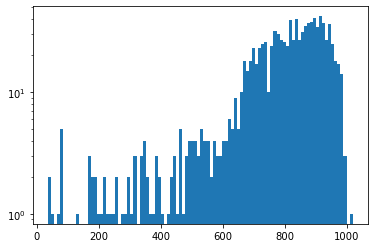

In [9]:


currentSpe_STRINGFulllPhyBalancePhylaPPI_posPPI,currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI=return_STRINGFulllPhyBalancePhylaPPI_benchmark_PPs(ML_pos_benchmarkFrame_dict,
                                                       input_allPPs_list
                                                                                                                                                   ,
                                                       Ecoli_string_score_dict,
                                                       limitedProFre=100000,
                                                      )

currentSpe_STRINGFulllPhyBalancePhylaPPI_frame_list=list()
for p1,p2 in currentSpe_STRINGFulllPhyBalancePhylaPPI_posPPI:
    currentSpe_STRINGFulllPhyBalancePhylaPPI_frame_list.append([p1,p2,"P",])

for p1,p2 in currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI:
    currentSpe_STRINGFulllPhyBalancePhylaPPI_frame_list.append([p1,p2,"N",])
currentSpe_STRINGFulllPhyBalancePhylaPPI_frame=pd.DataFrame(currentSpe_STRINGFulllPhyBalancePhylaPPI_frame_list,
                                                            columns=["STRING_ID1","STRING_ID2","benchmark_status"])

# currentSpe_STRINGFulllPhyBalancePhylaPPI_frame.to_csv("/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/allPPI_allInfo_frame.csv",
#                                                       sep="\t",header=True,index=None)






In [10]:
currentSpe_STRINGFulllPhyBalancePhylaPPI_frame.shape

(420412, 3)

# smaller benchmark dataset at  taxononical levels to test effect of different alignment strategies

It generated similar as above but we just dont limit the frequency of each protein of negative PPI to limit the dataset for the sake of computational time.

check code: PPI_Prediction_byCoevolution/src/utilities/script_CoEvo_EggNOG_preprocessing_STRING1105_varyEggNOGMaxLevels_prepareSTRINPhyPPIBenchmark.py


